In [25]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)


In [38]:
periodNum = 0
threshold = 2
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on']
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

def nextPeriod() :
    global periodNum
    periodNum = periodNum + 1
    return periodNum

def resetPeriods() :
    global periodNum
    periodNum = 0

In [27]:
df = prepare('datasets/samples.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11503813 entries, 0 to 11503812
Data columns (total 5 columns):
device_id         uint16
timestamp         datetime64[ns]
battery_level     uint8
network_status    object
screen_on         uint8
dtypes: datetime64[ns](1), object(1), uint16(1), uint8(2)
memory usage: 219.4+ MB


In [28]:
df['change'] = df.battery_level - df.battery_level.shift()
df.loc[df.device_id != df.device_id.shift(), 'change'] = None

In [29]:
def show_hist(s, bins, title, end=None, start=0, step=1, ylabel='# Samples', color='#66b3ff'):
    s.hist(bins=bins, color=color, edgecolor='k', linewidth=.5, figsize=(12,6))
    if (end != None):
        plt.xticks(np.arange(start, end, step))
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

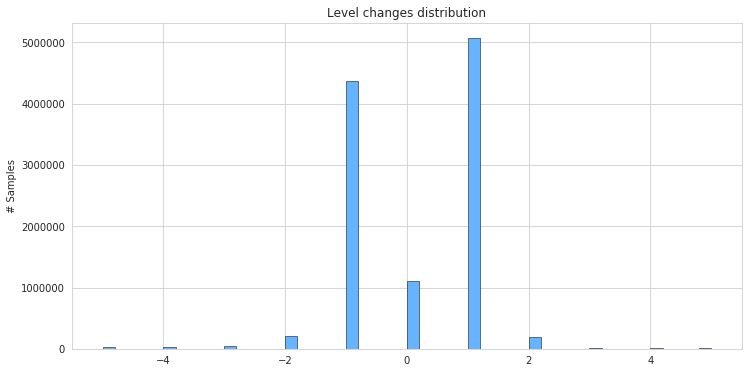

In [30]:
interval = 5

gl = df[(df['change'] >= -interval) & (df['change'] <= interval)]

show_hist(gl['change'], 50, 'Level changes distribution')

In [31]:
df['change_acc'] = df['change'].cumsum()
df.loc[df.device_id != df.device_id.shift(), 'change_acc'] = None

In [128]:
#temporary df to test
df2 = df.head(300).copy()
df2['period'] = 1

In [129]:


resetPeriods()
previousDirection = 0 # either -1, 1
currentDirection = 0 # either 1, 0, -1
directionChanged = False

sign = lambda x: x and (1, -1)[x < 0]

for index, row in df2.iterrows():
    
    rowChange = row['change']
    

    if (pd.isnull(rowChange)) : #if first sample of device, need to initialize directions
        previousDirection = df2.loc[(index+1,'change')]
        currentDirection = previousDirection
    else : 
        currentDirection = sign(rowChange) #either 1, -1, 0
        
    if (currentDirection != 0) : # either -1, 1 = the battery changed. if 0, then we keep the previousDirection
        if (currentDirection != previousDirection) : # the battery changed direction, else nothing changes
            directionChanged = True 
            previousDirection = currentDirection

    
    if ((index-1 >=0) and (row['device_id'] == df2.iloc[(index-1),0]) # same device as before and initial head
        and ((rowChange >= -threshold) and (rowChange <= threshold)) #within our threshold
       and (not directionChanged)): #no direction change
        df2.loc[index,'period'] = periodNum
    else:
        df2.loc[index,'period'] = nextPeriod()
        
    directionChanged = False #reset 
        
with pd.option_context('display.max_rows', None, 'display.max_columns', None): print(df2)


     device_id           timestamp  battery_level network_status  screen_on  \
0            1 2017-10-15 18:36:46             99            lte          1   
1            1 2017-10-15 18:41:54             98            lte          1   
2            1 2017-10-15 18:46:54             97            lte          1   
3            1 2017-10-15 18:50:35             96            lte          1   
4            1 2017-10-15 18:54:14             95            lte          1   
5            1 2017-10-15 18:54:14             95            lte          1   
6            1 2017-10-15 18:57:54             94            lte          1   
7            1 2017-10-15 19:02:47             93            lte          1   
8            1 2017-10-15 19:11:41             91            lte          1   
9            1 2017-10-15 19:21:25             89            lte          1   
10           1 2017-10-15 19:31:04             88            lte          1   
11           1 2017-10-15 19:44:42             85   

In [96]:
#df['time_diff'] = df['timestamp'].diff().dt.total_seconds()
#df['time_acc'] = df['time_diff'].cumsum()
#df.loc[df.device_id != df.device_id.shift(), 'time_acc'] = None

In [90]:
df.head(100)

,device_id,timestamp,battery_level,network_status,screen_on,change,change_acc
0,1,2017-10-15 18:36:46,99,lte,1,NaN,NaN
1,1,2017-10-15 18:41:54,98,lte,1,-1.0,-1.0
2,1,2017-10-15 18:46:54,97,lte,1,-1.0,-2.0
3,1,2017-10-15 18:50:35,96,lte,1,-1.0,-3.0
4,1,2017-10-15 18:54:14,95,lte,1,-1.0,-4.0
5,1,2017-10-15 18:54:14,95,lte,1,0.0,-4.0
6,1,2017-10-15 18:57:54,94,lte,1,-1.0,-5.0
7,1,2017-10-15 19:02:47,93,lte,1,-1.0,-6.0
8,1,2017-10-15 19:11:41,91,lte,1,-2.0,-8.0
9,1,2017-10-15 19:21:25,89,lte,1,-2.0,-10.0


In [48]:
sign = lambda x: x and (1, -1)[x < 0]

In [62]:
sign()

NameError: name 'NaN' is not defined